In [77]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.api import tsa
from sklearn.metrics import mean_absolute_error, mean_squared_error

/var/folders/z5/qndjgmp94tgckrl38gcbw_9h0000gn/T/ipykernel_4168/3276810634.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [140]:
df = pd.read_csv('/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv',index_col='date')
df_copy = df.copy()
df.index = pd.to_datetime(df.index)
df = df[df.index > '2020-10-10'] # Cut down the data before 2020-10-10
df.head()
df_state = df[df['location_name'] == 'Pennsylvania']
df_state_train = df_state.iloc[:-2, :]['value'] # Train set  
df_state_test = df_state.iloc[-2:, :]['value'] # Test set for validation
print(df_state_train.shape, df_state_test.shape)

(119,) (2,)


In [28]:
# cali_to_csv = pd.read_csv('/Users/xiangyikong/Desktop/Flu_preprocess/truth-Incident Hospitalizations.csv')
# cali_to_csv = cali_to_csv[cali_to_csv['location']=='06']
# cali_to_csv = cali_to_csv[:-2]
# cali_to_csv.to_csv('/Users/xiangyikong/Desktop/Flu_preprocess/cali_to_csv.csv', index=False)

In [25]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data 
seasonal_first_differencing = df_state_train.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -5.1031
p-value for Seasonal First Differencing: 0.0000


Text(0, 0.5, 'Autocorrelation')

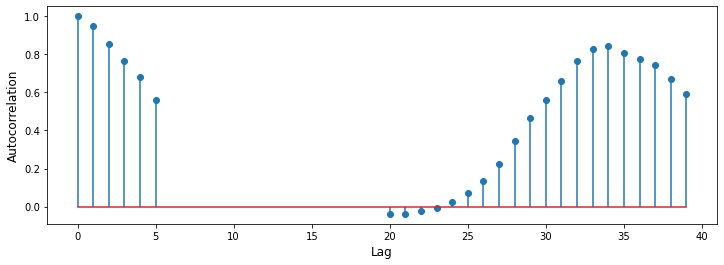

In [56]:
lags = [0,1,2,3,4,5,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39] 
autocorrs = [df_state_train.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

#### 8.5 month at lag of 34

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

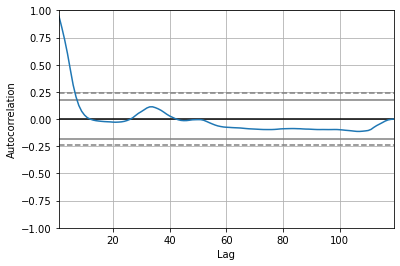

In [47]:
pd.plotting.autocorrelation_plot(df_state_train)

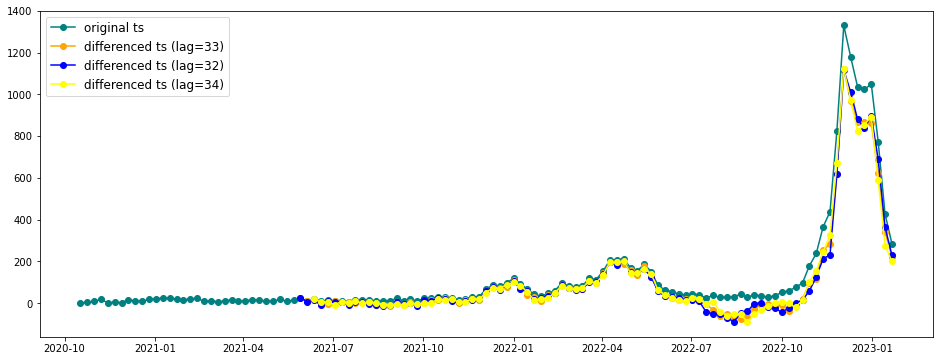

In [60]:
plt.figure(figsize=(16, 6))
plt.plot(df_state_train, '-o', color='teal', label="original ts")
plt.plot(df_state_train.diff(33), '-o', color='orange', label="differenced ts (lag=33)")
plt.plot(df_state_train.diff(32), '-o', color='blue', label="differenced ts (lag=32)")
plt.plot(df_state_train.diff(34), '-o', color='yellow', label="differenced ts (lag=34)")
plt.legend(fontsize=12)

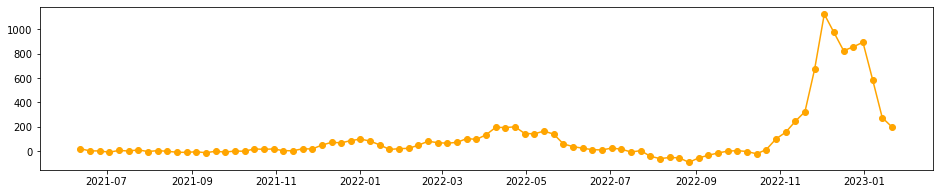

In [62]:
price_diff = df_state_train.diff(34).dropna() 

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')
time_series = price_diff 

#### AR

In [79]:
time_series.size

85

In [84]:
ar = tsa.AR(time_series)
optlag = ar.select_order(40, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag))

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/xiangyikong/opt/anaconda3/lib/p

Best optimal lag for ar model: 5


/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


MAE = 34.640
MAE2 = 41.163


/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

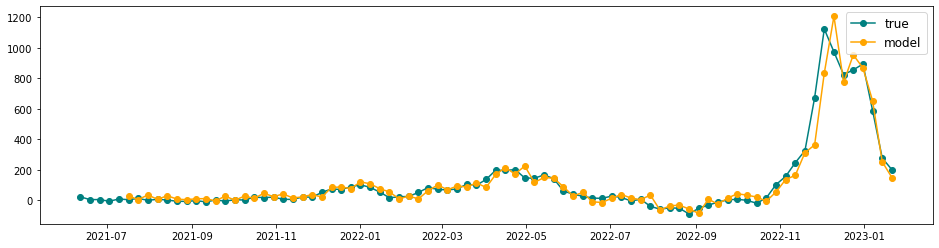

In [87]:
lag = optlag 
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-4:], ar_prediction[-4:]))) #error only for the last month

#### ARMA

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55524D+00    |proj g|=  1.11310D-01

At iterate    5    f=  5.55258D+00    |proj g|=  2.94511D-03

At iterate   10    f=  5.55255D+00    |proj g|=  4.30500D-04

At iterate   15    f=  5.55254D+00    |proj g|=  1.32356D-03

At iterate   20    f=  5.55254D+00    |proj g|=  6.04050D-04

At iterate   25    f=  5.55254D+00    |proj g|=  3.08020D-04

At iterate   30    f=  5.55253D+00    |proj g|=  1.84279D-03

At iterate   35    f=  5.55187D+00    |proj g|=  1.07869D-02

At iterate   40    f=  5.54492D+00    |proj g|=  6.43193D-02

At iterate   45    f=  5.54296D+00    |proj g|=  9.94236D-03


 This problem is unconstrained.



At iterate   50    f=  5.54290D+00    |proj g|=  4.23928D-04

At iterate   55    f=  5.54290D+00    |proj g|=  2.61124D-05

At iterate   60    f=  5.54290D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     63     92      1     0     0   2.487D-06   5.543D+00
  F =   5.5428997128970616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


MAE = 36.815
MAE2 = 30.126


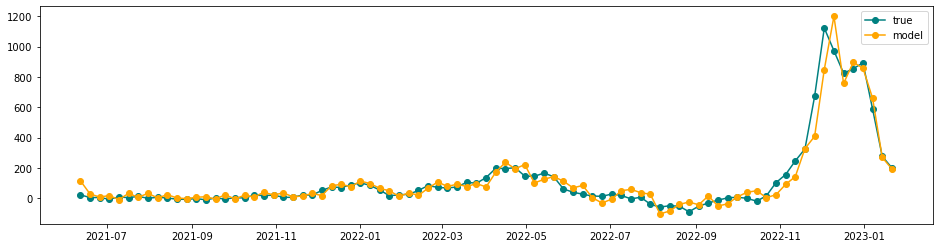

In [139]:
arma = tsa.ARMA(time_series, order=(5, 4)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=0
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-4:], arma_prediction[-4:]))) #error only for the last 90 days

In [108]:
time_series

date
2021-06-12     22.0
2021-06-19      4.0
2021-06-26      4.0
2021-07-03     -7.0
2021-07-10      8.0
              ...  
2022-12-24    855.0
2022-12-31    893.0
2023-01-07    588.0
2023-01-14    276.0
2023-01-21    200.0
Name: value, Length: 85, dtype: float64

In [131]:
#7 out of sample prediction with AR 
lag = 5
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+3)[-10:] 
ar_forecast

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'


2022-12-17    772.917997
2022-12-24    953.310064
2022-12-31    867.635913
2023-01-07    651.453196
2023-01-14    251.705870
2023-01-21    148.457614
2023-01-28     94.356480
2023-02-04   -196.494921
2023-02-11   -448.659686
2023-02-18   -513.434224
Freq: W-SAT, dtype: float64

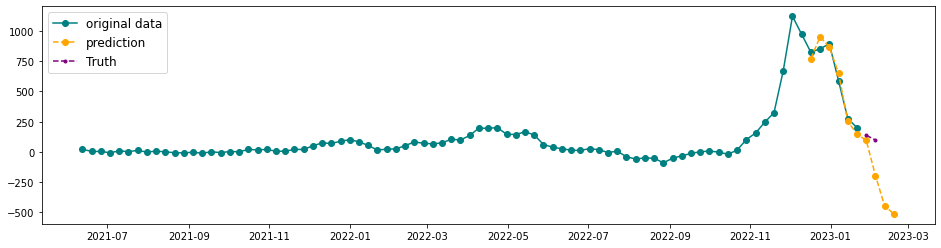

In [134]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)

In [106]:
df_state_test

date
2023-01-28    138
2023-02-04     98
Name: value, dtype: int64

In [130]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(5, 4)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+4)[-7:]
arma_forecast

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55524D+00    |proj g|=  1.11310D-01

At iterate    5    f=  5.55258D+00    |proj g|=  2.94511D-03

At iterate   10    f=  5.55255D+00    |proj g|=  4.30500D-04

At iterate   15    f=  5.55254D+00    |proj g|=  1.32356D-03

At iterate   20    f=  5.55254D+00    |proj g|=  6.04050D-04

At iterate   25    f=  5.55254D+00    |proj g|=  3.08020D-04

At iterate   30    f=  5.55253D+00    |proj g|=  1.84279D-03

At iterate   35    f=  5.55187D+00    |proj g|=  1.07869D-02

At iterate   40    f=  5.54492D+00    |proj g|=  6.43193D-02

At iterate   45    f=  5.54296D+00    |proj g|=  9.94236D-03

At iterate   50    f=  5.54290D+00    |proj g|=  4.23928D-04

At iterate   55    f=  5.54290D+00    |proj g|=  2.61124D-05

At iterate   60    f=  5.54290D+00    |proj g|=  8.88178D-07

           * * *

Tit   = 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2023-01-14    268.518047
2023-01-21    192.790376
2023-01-28    246.953157
2023-02-04    225.879203
2023-02-11    153.363634
2023-02-18    126.470803
2023-02-25    149.832108
Freq: W-SAT, dtype: float64

In [137]:
arma.predict()

/Users/xiangyikong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-06-12    115.952872
2021-06-19     28.429867
2021-06-26      6.950876
2021-07-03     17.139703
2021-07-10     -9.449549
                 ...    
2022-12-24    896.436386
2022-12-31    858.777047
2023-01-07    659.590521
2023-01-14    268.518047
2023-01-21    192.790376
Freq: W-SAT, Length: 85, dtype: float64

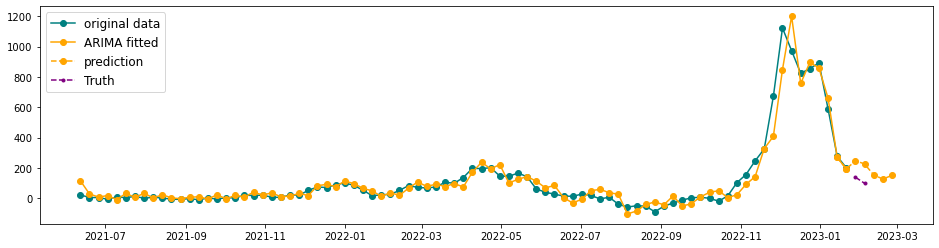

In [138]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma.predict(), '-o', label="ARIMA fitted", color='orange')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.plot(df_state_test, '--.', label='Truth', color='Purple')
plt.legend(fontsize=12)